# Extract data from dbSNP

Utilize the [Bio.Entrez package](https://biopython.org/docs/latest/api/Bio.Entrez.html) to get data from [dbSNP](https://www.ncbi.nlm.nih.gov/snp/).

## Setup
### Import packages

In [1]:
from collections import defaultdict
from xml.etree import ElementTree

import numpy as np
import pandas as pd
from Bio import Entrez
from rbc_gem_utils import (
    DATABASE_PATH,
    GEM_NAME,
    ROOT_PATH,
    build_string,
    get_annotation_df,
    read_rbc_model,
    show_versions,
    split_string,
)
from rbc_gem_utils.util import has_value_type

show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Load RBC-GEM model

In [2]:
model = read_rbc_model(filetype="xml")
model

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-21


Name,RBC_GEM
Memory address,110b02690
Number of metabolites,2157
Number of reactions,3275
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


In [3]:
annotation_type = "genes"
df_model_mappings = get_annotation_df(
    getattr(model, annotation_type), ["dbsnp"]
).rename({"id": annotation_type}, axis=1)
for col in df_model_mappings.columns:
    df = (
        df_model_mappings[col]
        .apply(lambda x: split_string(x))
        .explode(col)
        .drop_duplicates()
    )
    print(f"{df.name}: {df.nunique()}")

df_model_mappings

genes: 820
dbsnp: 5058


,genes,dbsnp
0,RPE,<NA>
1,RPIA,rs121918591
2,SORD,rs145813597;rs1042079;rs930337;rs149975952
3,AKR7A2,rs6670759;rs1043657;rs859208;rs859210;rs223120...
4,SRM,rs1049932
...,...,...
815,USP5,<NA>
816,VCPIP1,<NA>
817,VPS4B,rs17688948
818,WDR77,rs7416672


### Get IDs for query from model

In [4]:
df_model_snps = df_model_mappings.loc[:, ["genes", "dbsnp"]].copy()
df_model_snps["dbsnp"] = df_model_mappings["dbsnp"].apply(split_string)
df_model_snps = df_model_snps.explode("dbsnp")
df_model_snps = df_model_snps.dropna().drop_duplicates()
rs_ids = df_model_snps["dbsnp"].unique()
df_model_snps

,genes,dbsnp
1,RPIA,rs121918591
2,SORD,rs145813597
2,SORD,rs1042079
2,SORD,rs930337
2,SORD,rs149975952
...,...,...
814,UFD1,rs17744624
817,VPS4B,rs17688948
818,WDR77,rs7416672
819,YES1,rs34580680


In [5]:
def fetch_results_dbSNP(email, rs_ids):
    Entrez.email = email
    search = Entrez.efetch(db="snp", retmode="text", id=rs_ids)
    all_lines = search.readlines()
    search.close()
    return all_lines

### Get results from SNP as a DataFrame

In [6]:
overwrite = True
# Make sure to use your own email!
email = "zhaiman@ucsd.edu"

In [7]:
data = defaultdict(dict)
batch_size = 500
for batch_idx, batch in enumerate(np.arange(0, len(rs_ids), batch_size), start=0):
    query_ids = rs_ids[batch : batch + batch_size]
    print(
        f"Fetching results for batch {batch_idx + 1}  ({batch + len(query_ids)}/{len(rs_ids)})"
    )
    all_lines = fetch_results_dbSNP(email=email, rs_ids=query_ids)
    for entry_idx, xml_str in enumerate(all_lines, start=batch_idx * batch_size):
        entry = ElementTree.fromstring(xml_str)
        data[rs_ids[entry_idx]].update(
            {e.tag: e.text for e in entry if has_value_type(e)}
        )

# Make into DataFrame
df_snps_all = pd.DataFrame.from_dict(data, orient="index")
failed_ids = list(df_snps_all["error"].dropna().index)
print(f"\nNumber of failed IDs: {len(failed_ids)}")
df_snps_all.index.name = "dbsnp"
df_snps_all = df_snps_all[~df_snps_all["error"].notna()]
df_snps_all

Fetching results for batch 1  (500/5058)
Fetching results for batch 2  (1000/5058)
Fetching results for batch 3  (1500/5058)
Fetching results for batch 4  (2000/5058)
Fetching results for batch 5  (2500/5058)
Fetching results for batch 6  (3000/5058)
Fetching results for batch 7  (3500/5058)
Fetching results for batch 8  (4000/5058)
Fetching results for batch 9  (4500/5058)
Fetching results for batch 10  (5000/5058)
Fetching results for batch 11  (5058/5058)

Number of failed IDs: 3


,SNP_ID,GLOBAL_SAMPLESIZE,CLINICAL_SIGNIFICANCE,ACC,CHR,HANDLE,SPDI,FXN_CLASS,VALIDATED,DOCSUM,...,SS,ALLELE,SNP_CLASS,CHRPOS,CHRPOS_PREV_ASSM,SNP_ID_SORT,CLINICAL_SORT,CHRPOS_SORT,MERGED_SORT,error
dbsnp,,,,,,,,,,,,,,,,,,,,,
rs121918591,121918591,0,pathogenic,NC_000002.12,2,"TOPMED,OMIM-CURATED-RECORDS,PAGE_CC,GNOMAD,ILL...",NC_000002.12:88729278:C:T,"coding_sequence_variant,missense_variant","by-frequency,by-alfa,by-cluster","HGVS=NC_000002.12:g.88729279C>T,NC_000002.11:g...",...,"275518424,1958438289,2732810607,3021993357,365...",Y,snv,2:88729279,2:89028797,0121918591,1,0088729279,0,NaN
rs145813597,145813597,0,pathogenic-likely-pathogenic,NC_000015.10,15,"EVA-GONL,GNOMAD,EXOME_CHIP,EVA_DECODE,ILLUMINA...","NC_000015.10:45065302:C:A,NC_000015.10:4506530...","coding_sequence_variant,non_coding_transcript_...","by-frequency,by-alfa,by-cluster","HGVS=NC_000015.10:g.45065303C>A,NC_000015.10:g...",...,"342402496,464140601,491493966,491700043,991737...",H,snv,15:45065303,15:45357501,0145813597,1,0045065303,0,NaN
rs1042079,1042079,0,benign,NC_000015.10,15,"KRGDB,KHV_HUMAN_GENOMES,OMUKHERJEE_ADBS,SWEGEN...","NC_000015.10:45068981:A:G,NC_000015.10:4506898...","non_coding_transcript_variant,coding_sequence_...","by-frequency,by-alfa,by-cluster","HGVS=NC_000015.10:g.45068982A>G,NC_000015.10:g...",...,"1509008,4403349,76874733,95213358,156480828,15...",D,snv,15:45068982,15:45361180,0001042079,1,0045068982,0,NaN
rs930337,930337,0,benign,NC_000015.10,15,"KRGDB,OMUKHERJEE_ADBS,SWEGEN,TSC-CSHL,MGC_GENO...",NC_000015.10:45072335:A:C,"non_coding_transcript_variant,coding_sequence_...","by-frequency,by-alfa,by-cluster","HGVS=NC_000015.10:g.45072336A>C,NC_000015.9:g....",...,"1368774,2558685,3214527,5252928,21245444,24802...",M,snv,15:45072336,15:45364534,0000930337,1,0045072336,0,NaN
rs149975952,149975952,0,benign,NC_000015.10,15,"AFFY,1000GENOMES,ILLUMINA,SGDP_PRJ,EVA,SANFORD...","NC_000015.10:45073419:G:A,NC_000015.10:4507341...","coding_sequence_variant,non_coding_transcript_...","by-frequency,by-alfa,by-cluster","HGVS=NC_000015.10:g.45073420G>A,NC_000015.10:g...",...,"342402507,489048604,491493972,1353273008,16918...",D,snv,15:45073420,15:45365618,0149975952,1,0045073420,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs17744624,17744624,0,NaN,NC_000022.11,22,"GNOMAD,EXOME_CHIP,APPLERA_GI,USC_VALOUEV,EVA_G...","NC_000022.11:19467906:G:A,NC_000022.11:1946790...","missense_variant,coding_sequence_variant","by-frequency,by-alfa,by-cluster","HGVS=NC_000022.11:g.19467907G>A,NC_000022.11:g...",...,"24701832,48413642,69277235,69376500,74818968,8...",V,snv,22:19467907,22:19455430,0017744624,0,0019467907,0,NaN
rs17688948,17688948,0,NaN,NC_000018.10,18,"EVA_EXAC,PERLEGEN,EVA_DECODE,EVA_UK10K_TWINSUK...",NC_000018.10:63410411:G:C,"genic_upstream_transcript_variant,upstream_tra...","by-frequency,by-alfa,by-cluster","HGVS=NC_000018.10:g.63410412G>C,NC_000018.9:g....",...,"24492533,69217429,74820330,160453165,237511803...",S,snv,18:63410412,18:61077645,0017688948,0,0063410412,0,NaN
rs7416672,7416672,0,NaN,NC_000001.11,1,"SC_JCM,TOPMED,ILLUMINA,GNOMAD","NC_000001.11:111448776:C:A,NC_000001.11:111448...","missense_variant,coding_sequence_variant,upstr...","by-frequency,by-alfa,by-cluster","HGVS=NC_000001.11:g.111448777C>A,NC_000001.11:...",...,"11204945,160878283,482563863,2746395432,275957...",H,snv,1:111448777,1:111991399,0007416672,0,0111448777,0,NaN


### Parse and reformat results

In [8]:
df_model_snps = df_model_mappings.loc[:, ["genes", "dbsnp"]].copy()
df_model_snps["dbsnp"] = df_model_mappings["dbsnp"].apply(split_string)
df_model_snps = df_model_snps.explode("dbsnp")
df_model_snps = df_model_snps.dropna().drop_duplicates()
rs_ids = df_model_snps["dbsnp"].unique()
df_model_snps

rename_mapping = {
    key: key.lower()
    for key in df_snps_all.columns
    if key not in {"error", "GLOBAL_SAMPLESIZE"}
}

df_model_snps = df_model_snps.merge(
    df_snps_all.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1),
    left_on="dbsnp",
    right_on="dbsnp",
    how="inner",
)
for col in df_model_snps.columns:
    df_model_snps[col] = df_model_snps[col].str.split(",")
    # Switch to default seperator (currently semicolon)
    df_model_snps[col] = df_model_snps[col].apply(lambda x: build_string(x))
df_model_snps = df_model_snps.sort_values(["snp_id_sort"]).reset_index(drop=True)
df_model_snps["sequence_change"] = (
    df_model_snps["spdi"]
    .dropna()
    .apply(lambda value: [s.split(":", 2)[-1] for s in split_string(value)])
)
df_model_snps

,genes,dbsnp,snp_id,clinical_significance,acc,chr,handle,spdi,fxn_class,validated,...,ss,allele,snp_class,chrpos,chrpos_prev_assm,snp_id_sort,clinical_sort,chrpos_sort,merged_sort,sequence_change
0,HBB,rs334,334,benign;conflicting-interpretations-of-pathogen...,NC_000011.10,11,EVA;ILLUMINA;GNOMAD;KHV_HUMAN_GENOMES;PERLEGEN...,NC_000011.10:5227001:T:A;NC_000011.10:5227001:...,missense_variant;coding_sequence_variant,by-frequency;by-alfa;by-cluster,...,335;24811263;48419811;49850538;49850540;498505...,N,snv,11:5227002,11:5248232,0000000334,1,0005227002,0,"[T:A, T:C, T:G]"
1,AGT,rs699,699,benign;risk-factor,NC_000001.11,1,ACPOP;LEE;EVA_UK10K_TWINSUK;OMUKHERJEE_ADBS;EG...,NC_000001.11:230710047:A:G,missense_variant;coding_sequence_variant,by-frequency;by-alfa;by-cluster,...,704;5428;6484;1510443;3240877;3474289;4404260;...,R,snv,1:230710048,1:230845794,0000000699,1,0230710048,0,[A:G]
2,GSTP1,rs1695,1695,not-provided;benign,NC_000011.10,11,BCMHGSC_JDW;WI_SSAHASNP;EXOME_CHIP;ILLUMINA-UK...,NC_000011.10:67585217:A:G;NC_000011.10:6758521...,missense_variant;coding_sequence_variant,by-frequency;by-alfa;by-cluster,...,1720;5330;9110;1390210;1545478;3178003;5586573...,D,snv,11:67585218,11:67352689,0000001695,1,0067585218,0,"[A:G, A:T]"
3,MPO,rs2759,2759,NaN,NC_000017.11,17,WIPGA;EVA_GENOME_DK;SANFORD_IMAGENETICS;EVA_EX...,NC_000017.11:58270744:T:C,coding_sequence_variant;missense_variant,by-frequency;by-alfa;by-cluster,...,2789;16338615;23791841;38350281;69199282;74862...,Y,snv,17:58270745,17:56348106,0000002759,0,0058270745,0,[T:C]
4,FKBP2,rs4672,4672,NaN,NC_000011.10,11,EVA;ABI;USC_VALOUEV;ILLUMINA;HUMANGENOME_JCVI;...,NC_000011.10:64242406:G:A;NC_000011.10:6424240...,3_prime_UTR_variant;missense_variant;intron_va...,by-frequency;by-alfa;by-cluster,...,1555019;4436250;20825221;24790172;39886556;752...,D,snv,11:64242407,11:64009879,0000004672,0,0064242407,0,"[G:A, G:T]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5050,CLCN3,rs2150238934,2150238934,pathogenic;likely-pathogenic,NC_000004.12,4,None,NC_000004.12:169680142:A:G,missense_variant;coding_sequence_variant,NaN,...,0,R,snv,4:169680143,4:170601294,2150238934,1,0169680143,0,[A:G]
5051,CLCN3,rs2150254146,2150254146,pathogenic;likely-pathogenic,NC_000004.12,4,None,NC_000004.12:169695645:T:C,missense_variant;coding_sequence_variant;intro...,NaN,...,0,Y,snv,4:169695646,4:170616797,2150254146,1,0169695646,0,[T:C]
5052,CLCN3,rs2150267036,2150267036,pathogenic;likely-pathogenic,NC_000004.12,4,None,NC_000004.12:169706936:T:C,missense_variant;coding_sequence_variant,NaN,...,0,Y,snv,4:169706937,4:170628088,2150267036,1,0169706937,0,[T:C]
5053,CLCN3,rs2150274994,2150274994,pathogenic;likely-pathogenic,NC_000004.12,4,None,NC_000004.12:169713243:T:C,missense_variant;coding_sequence_variant,NaN,...,0,Y,snv,4:169713244,4:170634395,2150274994,1,0169713244,0,[T:C]


### Export data

In [9]:
if overwrite:
    df_model_snps.to_csv(ROOT_PATH / DATABASE_PATH / f"snps_{GEM_NAME}.tsv", sep="\t")
else:
    df_model_snps.to_csv(ROOT_PATH / INTERIM_PATH / f"snps_{GEM_NAME}.tsv", sep="\t")
df_model_snps

,genes,dbsnp,snp_id,clinical_significance,acc,chr,handle,spdi,fxn_class,validated,...,ss,allele,snp_class,chrpos,chrpos_prev_assm,snp_id_sort,clinical_sort,chrpos_sort,merged_sort,sequence_change
0,HBB,rs334,334,benign;conflicting-interpretations-of-pathogen...,NC_000011.10,11,EVA;ILLUMINA;GNOMAD;KHV_HUMAN_GENOMES;PERLEGEN...,NC_000011.10:5227001:T:A;NC_000011.10:5227001:...,missense_variant;coding_sequence_variant,by-frequency;by-alfa;by-cluster,...,335;24811263;48419811;49850538;49850540;498505...,N,snv,11:5227002,11:5248232,0000000334,1,0005227002,0,"[T:A, T:C, T:G]"
1,AGT,rs699,699,benign;risk-factor,NC_000001.11,1,ACPOP;LEE;EVA_UK10K_TWINSUK;OMUKHERJEE_ADBS;EG...,NC_000001.11:230710047:A:G,missense_variant;coding_sequence_variant,by-frequency;by-alfa;by-cluster,...,704;5428;6484;1510443;3240877;3474289;4404260;...,R,snv,1:230710048,1:230845794,0000000699,1,0230710048,0,[A:G]
2,GSTP1,rs1695,1695,not-provided;benign,NC_000011.10,11,BCMHGSC_JDW;WI_SSAHASNP;EXOME_CHIP;ILLUMINA-UK...,NC_000011.10:67585217:A:G;NC_000011.10:6758521...,missense_variant;coding_sequence_variant,by-frequency;by-alfa;by-cluster,...,1720;5330;9110;1390210;1545478;3178003;5586573...,D,snv,11:67585218,11:67352689,0000001695,1,0067585218,0,"[A:G, A:T]"
3,MPO,rs2759,2759,NaN,NC_000017.11,17,WIPGA;EVA_GENOME_DK;SANFORD_IMAGENETICS;EVA_EX...,NC_000017.11:58270744:T:C,coding_sequence_variant;missense_variant,by-frequency;by-alfa;by-cluster,...,2789;16338615;23791841;38350281;69199282;74862...,Y,snv,17:58270745,17:56348106,0000002759,0,0058270745,0,[T:C]
4,FKBP2,rs4672,4672,NaN,NC_000011.10,11,EVA;ABI;USC_VALOUEV;ILLUMINA;HUMANGENOME_JCVI;...,NC_000011.10:64242406:G:A;NC_000011.10:6424240...,3_prime_UTR_variant;missense_variant;intron_va...,by-frequency;by-alfa;by-cluster,...,1555019;4436250;20825221;24790172;39886556;752...,D,snv,11:64242407,11:64009879,0000004672,0,0064242407,0,"[G:A, G:T]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5050,CLCN3,rs2150238934,2150238934,pathogenic;likely-pathogenic,NC_000004.12,4,None,NC_000004.12:169680142:A:G,missense_variant;coding_sequence_variant,NaN,...,0,R,snv,4:169680143,4:170601294,2150238934,1,0169680143,0,[A:G]
5051,CLCN3,rs2150254146,2150254146,pathogenic;likely-pathogenic,NC_000004.12,4,None,NC_000004.12:169695645:T:C,missense_variant;coding_sequence_variant;intro...,NaN,...,0,Y,snv,4:169695646,4:170616797,2150254146,1,0169695646,0,[T:C]
5052,CLCN3,rs2150267036,2150267036,pathogenic;likely-pathogenic,NC_000004.12,4,None,NC_000004.12:169706936:T:C,missense_variant;coding_sequence_variant,NaN,...,0,Y,snv,4:169706937,4:170628088,2150267036,1,0169706937,0,[T:C]
5053,CLCN3,rs2150274994,2150274994,pathogenic;likely-pathogenic,NC_000004.12,4,None,NC_000004.12:169713243:T:C,missense_variant;coding_sequence_variant,NaN,...,0,Y,snv,4:169713244,4:170634395,2150274994,1,0169713244,0,[T:C]


### Visualize genetic landscape

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

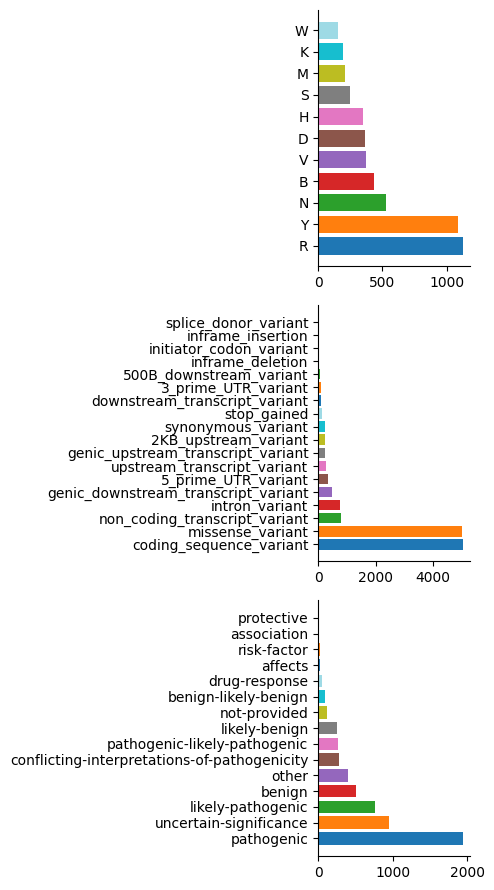

In [11]:
df_snps_per_gene = (
    df_model_snps.groupby("genes")["dbsnp"]
    .agg(lambda x: x.nunique())
    .sort_values(ascending=False)
)
df_snp_fxn_class = (
    df_model_snps["fxn_class"].apply(split_string).explode().value_counts()
)
df_snp_clinical_significance = (
    df_model_snps["clinical_significance"].apply(split_string).explode().value_counts()
)
df_snp_allele = df_model_snps["allele"].apply(split_string).explode().value_counts()

fig, axes = plt.subplots(3, 1, figsize=(5, 9))
(ax_allele, ax_fxn_class, ax_clinical_significance) = axes.flatten()
sns.despine(fig)
cmin = 0
cmax = 1
colors = mpl.colormaps["tab20"](np.linspace(cmin, cmax, len(df_snp_allele.index)))

ax_allele.barh(
    df_snp_allele.index,
    df_snp_allele.values,
    color=colors,
)
ax_fxn_class.barh(
    df_snp_fxn_class.index,
    df_snp_fxn_class.values,
    color=colors,
)
ax_clinical_significance.barh(
    df_snp_clinical_significance.index,
    df_snp_clinical_significance.values,
    color=colors,
)
fig.tight_layout()